<h1>Task 3.4</h1>
By B913717

In [1]:
import mlhelper as mlh
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

<h2>Clustering on Regression</h2>
We take a look at performing K-means clustering regression on the gwp dataset.

In [2]:
gwp_dataset = mlh.GWPDataset("gwp_assessment.csv")
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(
    gwp_dataset.processed_X(), gwp_dataset.processed_Y(),
    train_size=0.8, shuffle=True)

First we define a function which allows us to perform hyperparameter optimisation to find the best k means.

In [3]:
def k_means_search(min_clusters, max_clusters, metric, x_train, y_train, x_val, y_val):
    best = None
    best_acc = 0.0
    results = []
    for i in range(min_clusters, max_clusters + 1):
        k_means = MiniBatchKMeans(n_clusters=i, n_init='auto').fit(x_train)
        acc = metric(k_means, y_train, x_val, y_val) #evaluate performance on given metric.
        results = results + [acc]
        if(acc > best_acc):
            best = k_means
            best_acc = acc
            
    return (best, best_acc, results)
        

And we define a MSE metric for k means.

In [4]:
def k_means_mse(k_means, y_train, x_test, y_test):
    #maps clusters to the mean of their elements.
    cluster_to_mean = np.empty(k_means.n_clusters)
    
    #generate map.
    for i in range(0, k_means.n_clusters):
        samples_in_cluster = y_train[k_means.labels_ == i]
        cluster_to_mean[i] = np.mean(samples_in_cluster)
        
    #calculate mse between the mean of the cluster and real value of the sample.
    square_errors = np.empty(y_test.size)
    predictions = k_means.predict(x_test)
    for i in range(0, x_test.shape[0]):
        square_errors[i] = \
        (cluster_to_mean[predictions[i]] - y_test[i])**2
        
    return ((1 / y_test.size) * np.sum(square_errors))

Now we optimise the k_mean hyperparameters. Note: Warnings appear when trying to find the mean of empty clusters for larger values of k. Doesn't effect final outcome however.

In [8]:
gwp_results = k_means_search(2, 100, k_means_mse, gwp_x_train, gwp_y_train,
                            gwp_x_test, gwp_y_test)

c:\python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'MSE')

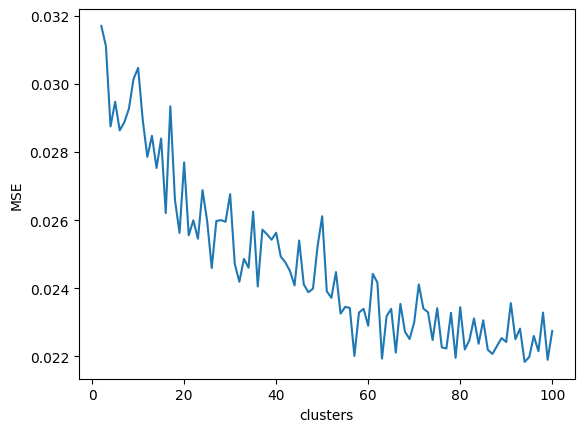

In [9]:
fig, axs = plt.subplots()
axs.plot(np.arange(2, 101, 1), gwp_results[2])
axs.set_xlabel("clusters")
axs.set_ylabel("MSE")

As the number of clusters increases, the MSE decreases. I expect this is due to the increasing number of clusters allowing for smaller groupings of more similar samples which in turn brings the mean of each cluster closer to the value of its members. The MSE decrease is turbulant and does seem to be reaching a plateau however.

<h2>Clustering on Classification</h2>
We take a look at performing K-Means classification on the star dataset.

In [10]:
star_dataset = mlh.StarDataset("star_assessment.csv")
#Split into training and testing.
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(
    star_dataset.processed_X(), star_dataset.processed_Y(),
    train_size=0.8, shuffle=True, stratify=star_dataset.processed_Y())

We define an accuracy metric for clustering.

In [11]:
def k_means_accuracy(k_means, y_train, x_test, y_test):
    #maps cluster to the class it represents.
    cluster_to_class = np.empty(k_means.n_clusters)

    #calculate mapping.
    for i in range(0, k_means.n_clusters):
        samples_in_cluster = y_train[k_means.labels_ == i]
        classes_in_cluster, classes_count = np.unique(samples_in_cluster, return_counts=True)
        cluster_to_class[i] = classes_in_cluster[np.argmax(classes_count)]
        
    
    predictions = k_means.predict(x_test)
    class_predictions = np.empty(x_test.shape[0])
    #map each prediction to its corresponding class
    for i in range(0, x_test.shape[0]):
        class_predictions[i] = cluster_to_class[predictions[i]]
        
    return np.sum(class_predictions == y_test) / y_test.size
    

In [12]:
star_results = k_means_search(2, 100, k_means_accuracy, star_x_train, star_y_train, star_x_test, star_y_test)

Now we plot it

Text(0, 0.5, 'accuracy')

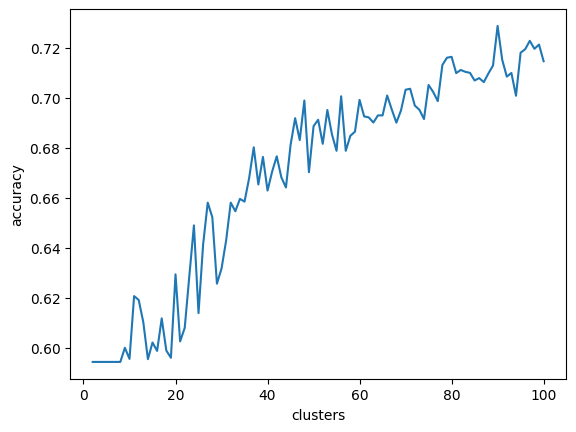

In [13]:
fig, axs = plt.subplots()
axs.plot(np.arange(2, 101, 1), star_results[2])
axs.set_xlabel("clusters")
axs.set_ylabel("accuracy")

We see an accuracy increase as clusters increases. I expect this is due to an increased number of clusters allowing for smaller clusters of more similar samples which where in turn likely to share their class. The gradient of the curve does seem to be decreasing however, so it seems unlikely that it would reach far above 80% accuracy. Unfortunately, I lack the computing power to push it so far.

In [14]:
print("Best k means accuracy: " + str(star_results[1]))

Best k means accuracy: 0.7287


<h2>Markdown Question</h2>

SVC was able to achieve accuracy of 96%. While I was unable to find the maximum accuracy of k means clustering, the curve suggests it was beginning to reach its maximum and was unlikely to exceed 80% accuracy. Therefore, classification algorithms performed better on the star dataset.